## IBIS2024 1-R-48 量子回路での一般グラフのマッチング状態の重ね合わせ表現の再現実験。
- グラフの各辺をそれぞれの量子ビットに割り当てる。
- 辺が無いとき$\ket{0}$、辺があるとき$\ket{1}$とする。
- 1つの頂点から幅優先探索的に辺を探索していく。

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

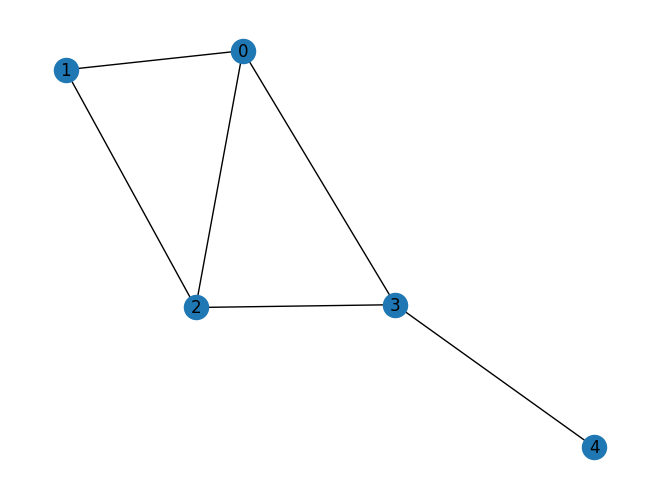

In [2]:
n_nodes = 5
n_edges = 6

nodes = [i for i in range(n_nodes)]
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4)] # 辺の順番と、量子ビットの順番は合わせる必要あり。

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nx.draw(G, with_labels=True)
plt.show()

In [3]:
def get_matching_states(nodes: list[int], edges: list[(int, int)]) -> list:
    # マッチング状態を数え上げ、及び、最大マッチング状態の探索
    # bit全探索

    n_edges = len(edges)
    n_nodes = len(nodes)

    all_states = []
    for bit in range(2**n_edges):
        state = []
        for i in range(n_edges):
            if bit & (2**i):
                state.append(1)
            else:
                state.append(0)
        all_states.append(state)

    # print('len(states) =', len(states))
    # print('states =', states)

    n_matching = 0
    matching_states = [] # (番号、状態、matching数)の組で保持
    for num, state in enumerate(all_states):
        print('state =', state)
        to = [[] for _ in range(n_nodes)]
        for i in range(len(state)):
            if state[i] == 1:
                to[edges[i][0]].append(edges[i][1])
                to[edges[i][1]].append(edges[i][0])
        print('to =', to)
        print()

        is_matching = True
        for e in to:
            if len(e) >= 2:
                is_matching = False
            if not is_matching:
                break
        if not is_matching:
            continue

        matching_states.append((num, state, sum(state)))
        n_matching += 1
    print('n_matching =', n_matching)

    return matching_states

In [4]:
matching_states = get_matching_states(nodes, edges)

state = [0, 0, 0, 0, 0, 0]
to = [[], [], [], [], []]

state = [1, 0, 0, 0, 0, 0]
to = [[1], [0], [], [], []]

state = [0, 1, 0, 0, 0, 0]
to = [[2], [], [0], [], []]

state = [1, 1, 0, 0, 0, 0]
to = [[1, 2], [0], [0], [], []]

state = [0, 0, 1, 0, 0, 0]
to = [[3], [], [], [0], []]

state = [1, 0, 1, 0, 0, 0]
to = [[1, 3], [0], [], [0], []]

state = [0, 1, 1, 0, 0, 0]
to = [[2, 3], [], [0], [0], []]

state = [1, 1, 1, 0, 0, 0]
to = [[1, 2, 3], [0], [0], [0], []]

state = [0, 0, 0, 1, 0, 0]
to = [[], [2], [1], [], []]

state = [1, 0, 0, 1, 0, 0]
to = [[1], [0, 2], [1], [], []]

state = [0, 1, 0, 1, 0, 0]
to = [[2], [2], [0, 1], [], []]

state = [1, 1, 0, 1, 0, 0]
to = [[1, 2], [0, 2], [0, 1], [], []]

state = [0, 0, 1, 1, 0, 0]
to = [[3], [2], [1], [0], []]

state = [1, 0, 1, 1, 0, 0]
to = [[1, 3], [0, 2], [1], [0], []]

state = [0, 1, 1, 1, 0, 0]
to = [[2, 3], [2], [0, 1], [0], []]

state = [1, 1, 1, 1, 0, 0]
to = [[1, 2, 3], [0, 2], [0, 1], [0], []]

state = [0, 0, 0, 0, 1, 0]
to = [[],

In [5]:
print(matching_states)

c_state_list = []
for e in matching_states:
    c_state_list.append(e[0])

[(0, [0, 0, 0, 0, 0, 0], 0), (1, [1, 0, 0, 0, 0, 0], 1), (2, [0, 1, 0, 0, 0, 0], 1), (4, [0, 0, 1, 0, 0, 0], 1), (8, [0, 0, 0, 1, 0, 0], 1), (12, [0, 0, 1, 1, 0, 0], 2), (16, [0, 0, 0, 0, 1, 0], 1), (17, [1, 0, 0, 0, 1, 0], 2), (32, [0, 0, 0, 0, 0, 1], 1), (33, [1, 0, 0, 0, 0, 1], 2), (34, [0, 1, 0, 0, 0, 1], 2), (40, [0, 0, 0, 1, 0, 1], 2)]


In [6]:
print(len(c_state_list))
print(c_state_list)

12
[0, 1, 2, 4, 8, 12, 16, 17, 32, 33, 34, 40]


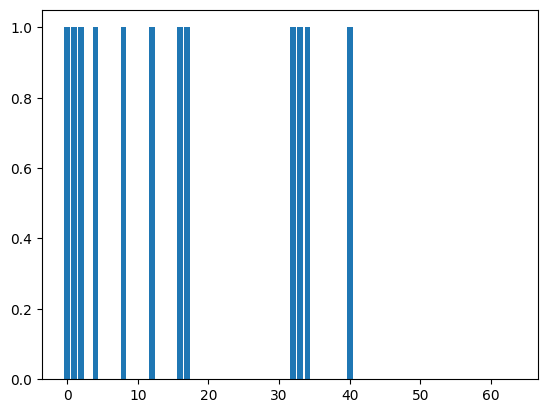

In [7]:
d = [0 for _ in range(64)]
for i, state, num in matching_states:
    d[i] = 1

plt.figure()
x = range(64)
y = d
plt.bar(x, y)
plt.show()

---
### 量子回路でマッチングの重ね合わせを表現

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import HGate
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex

In [9]:
def mc_h(control_qubits, target_qubit):
    '''
    多重制御Hadamardゲート

    Args:
        control_qubits (list[int]): 制御ビットとして設定したいキュービット番号のリスト。例：[0, 1, 3]など
        target_qubit (int): ターゲットとして設定したいキュービット番号
    '''
    num_controls = len(control_qubits)
    num_qubits = max(control_qubits + [target_qubit]) + 1
    qc = QuantumCircuit(num_qubits)
    hgate = HGate()
    controlled_hadamard = hgate.control(num_controls)
    qc.append(controlled_hadamard, control_qubits + [target_qubit])

    return qc

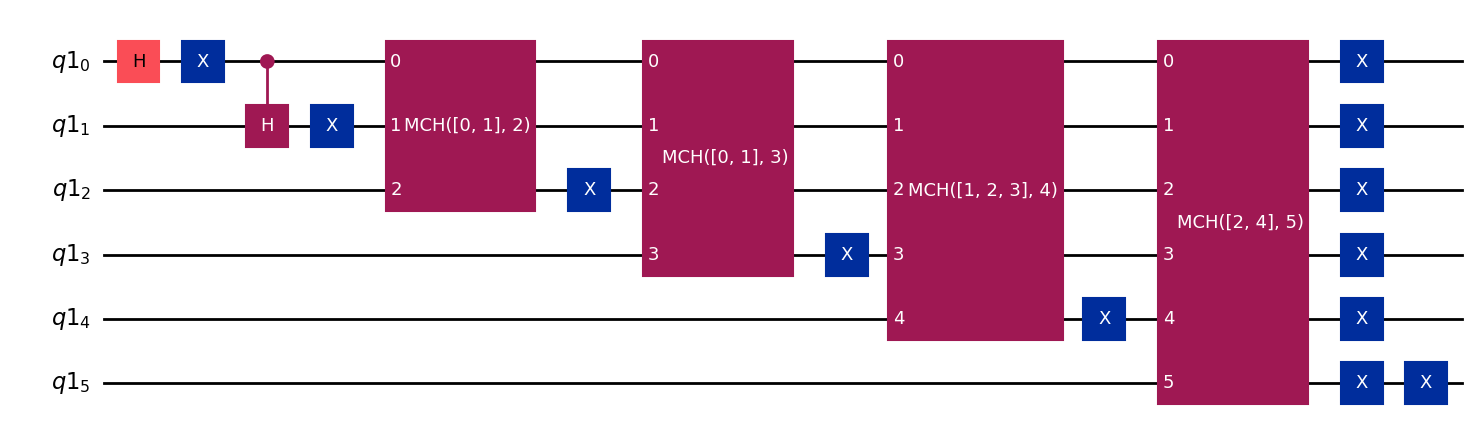

In [10]:
qc = QuantumCircuit()
qr = QuantumRegister(n_edges)
qc.add_register(qr)

qc.h(0)
qc.x(0)

qc.ch(0, 1)
# mch_gate = mc_h([0], 1).to_gate(label='MCH')
# qc.append(mch_gate, [0, 1])
qc.x(1)

mch_gate = mc_h([0, 1], 2).to_gate(label='MCH([0, 1], 2)')
qc.append(mch_gate, [0, 1, 2])
qc.x(2)

mch_gate = mc_h([0, 1], 3).to_gate(label='MCH([0, 1], 3)')
qc.append(mch_gate, [0, 1, 2, 3])
qc.x(3)

mch_gate = mc_h([1, 2, 3], 4).to_gate(label='MCH([1, 2, 3], 4)')
qc.append(mch_gate, [0, 1, 2, 3, 4])
qc.x(4)

mch_gate = mc_h([2, 4], 5).to_gate(label='MCH([2, 4], 5)')
qc.append(mch_gate, [0, 1, 2, 3, 4, 5])
qc.x(5)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(4)
qc.x(5)

qc.draw('mpl')

In [11]:
sim = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend=sim)
res = sim.run(qc).result()
state = res.data()['statevector']
array_to_latex(state, prefix='state =')

<IPython.core.display.Latex object>

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


<BarContainer object of 64 artists>

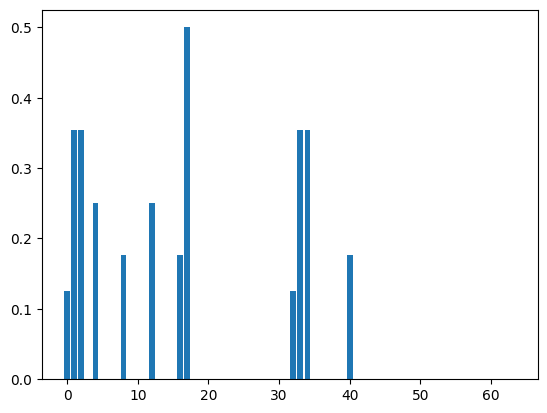

In [12]:
plt.bar(range(2**6), state)

In [13]:
q_state_list = []
for i, s in enumerate(state):
    print(f'{i}: {np.abs(s)}')
    if np.abs(s) >= 0.01:
        q_state_list.append(i)


0: 0.12499999999999997
1: 0.35355339059327384
2: 0.35355339059327384
3: 7.878763007045448e-17
4: 0.25000000000000006
5: 1.2325951644078318e-32
6: 0.0
7: 0.0
8: 0.17677669529663692
9: 1.96261557335472e-17
10: 0.0
11: 0.0
12: 0.2500000000000001
13: 0.0
14: 0.0
15: 0.0
16: 0.17677669529663698
17: 0.5000000000000002
18: 8.900933018370749e-17
19: 1.2705300141197633e-32
20: 1.510656218090215e-17
21: 1.1211578427767056e-48
22: 0.0
23: 0.0
24: 1.8014014492744945e-17
25: 1.8049898154812098e-33
26: 0.0
27: 0.0
28: 1.625790292081742e-17
29: 0.0
30: 0.0
31: 0.0
32: 0.12499999999999997
33: 0.35355339059327384
34: 0.35355339059327384
35: 7.878763007045448e-17
36: 0.0
37: 9.495567745759799e-66
38: 0.0
39: 0.0
40: 0.17677669529663692
41: 1.96261557335472e-17
42: 0.0
43: 0.0
44: 1.3877787807814457e-17
45: 0.0
46: 0.0
47: 0.0
48: 0.0
49: 2.7755575615628914e-17
50: 0.0
51: 0.0
52: 0.0
53: 0.0
54: 0.0
55: 0.0
56: 0.0
57: 8.552847072295026e-50
58: 0.0
59: 0.0
60: 0.0
61: 0.0
62: 0.0
63: 0.0


/tmp/ipykernel_9861/2876000424.py:2: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, s in enumerate(state):


In [14]:
print(len(q_state_list))
print(q_state_list)

12
[0, 1, 2, 4, 8, 12, 16, 17, 32, 33, 34, 40]


In [15]:
print(len(c_state_list))
print(c_state_list)

12
[0, 1, 2, 4, 8, 12, 16, 17, 32, 33, 34, 40]


---
### もっと単純なグラフでやってみる

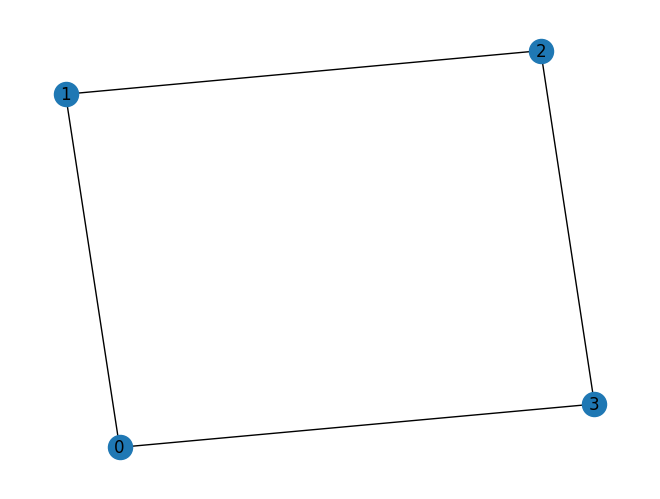

In [16]:
n_nodes = 4
n_edges = 4

nodes = [i for i in range(n_nodes)]
# edges = [(0, 1), (1, 2), (2, 3), (3, 0)]
edges = [(0, 1), (0, 3), (1, 2), (2, 3)]

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nx.draw(G, with_labels=True)
plt.show()

In [17]:
matching_states = get_matching_states(nodes, edges)
print(matching_states)


state = [0, 0, 0, 0]
to = [[], [], [], []]

state = [1, 0, 0, 0]
to = [[1], [0], [], []]

state = [0, 1, 0, 0]
to = [[3], [], [], [0]]

state = [1, 1, 0, 0]
to = [[1, 3], [0], [], [0]]

state = [0, 0, 1, 0]
to = [[], [2], [1], []]

state = [1, 0, 1, 0]
to = [[1], [0, 2], [1], []]

state = [0, 1, 1, 0]
to = [[3], [2], [1], [0]]

state = [1, 1, 1, 0]
to = [[1, 3], [0, 2], [1], [0]]

state = [0, 0, 0, 1]
to = [[], [], [3], [2]]

state = [1, 0, 0, 1]
to = [[1], [0], [3], [2]]

state = [0, 1, 0, 1]
to = [[3], [], [3], [0, 2]]

state = [1, 1, 0, 1]
to = [[1, 3], [0], [3], [0, 2]]

state = [0, 0, 1, 1]
to = [[], [2], [1, 3], [2]]

state = [1, 0, 1, 1]
to = [[1], [0, 2], [1, 3], [2]]

state = [0, 1, 1, 1]
to = [[3], [2], [1, 3], [0, 2]]

state = [1, 1, 1, 1]
to = [[1, 3], [0, 2], [1, 3], [0, 2]]

n_matching = 7
[(0, [0, 0, 0, 0], 0), (1, [1, 0, 0, 0], 1), (2, [0, 1, 0, 0], 1), (4, [0, 0, 1, 0], 1), (6, [0, 1, 1, 0], 2), (8, [0, 0, 0, 1], 1), (9, [1, 0, 0, 1], 2)]


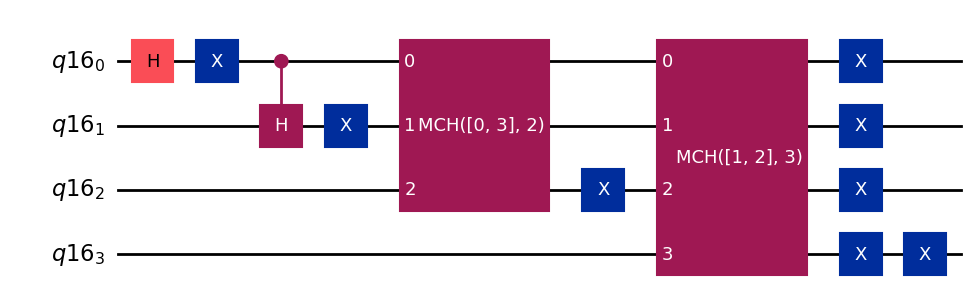

In [18]:
qc = QuantumCircuit()
qr = QuantumRegister(n_edges)
qc.add_register(qr)

qc.h(0)
qc.x(0)

qc.ch(0, 1)
# mch_gate = mc_h([0], 1).to_gate(label='MCH')
# qc.append(mch_gate, [0, 1])
qc.x(1)

mch_gate = mc_h([0], 2).to_gate(label='MCH([0, 3], 2)')
qc.append(mch_gate, [0, 1, 2])
qc.x(2)

mch_gate = mc_h([1, 2], 3).to_gate(label='MCH([1, 2], 3)')
qc.append(mch_gate, [0, 1, 2, 3])
qc.x(3)

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)

qc.draw('mpl')

In [19]:
sim = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend=sim)
res = sim.run(qc).result()
state = res.data()['statevector']
array_to_latex(state, prefix='state =')

<IPython.core.display.Latex object>

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


<BarContainer object of 16 artists>

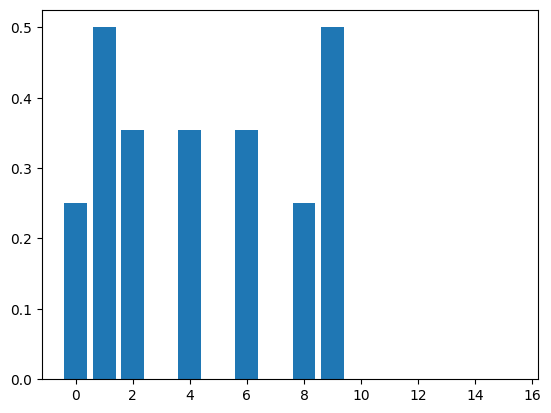

In [20]:
plt.bar(range(2**4), state)

In [21]:
print(matching_states)

c_state_list = []
for e in matching_states:
    c_state_list.append(e[0])

[(0, [0, 0, 0, 0], 0), (1, [1, 0, 0, 0], 1), (2, [0, 1, 0, 0], 1), (4, [0, 0, 1, 0], 1), (6, [0, 1, 1, 0], 2), (8, [0, 0, 0, 1], 1), (9, [1, 0, 0, 1], 2)]


In [22]:
q_state_list = []
for i, s in enumerate(state):
    print(f'{i}: {np.abs(s)}')
    if np.abs(s) >= 0.01:
        q_state_list.append(i)

0: 0.24999999999999994
1: 0.49999999999999994
2: 0.3535533905932737
3: 1.1169206562551344e-16
4: 0.3535533905932737
5: 1.1338735305352004e-16
6: 0.3535533905932736
7: 2.4663937413007216e-32
8: 0.24999999999999994
9: 0.5
10: 0.0
11: 0.0
12: 1.3877787807814457e-17
13: 0.0
14: 1.3877787807814457e-17
15: 0.0


/tmp/ipykernel_9861/4047471416.py:2: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, s in enumerate(state):


In [23]:
print(len(q_state_list))
print(q_state_list)

7
[0, 1, 2, 4, 6, 8, 9]


In [24]:
print(len(c_state_list))
print(c_state_list)

7
[0, 1, 2, 4, 6, 8, 9]
